<a href="https://colab.research.google.com/github/tshabalalasibongile/Molecular-Fingerprinting/blob/main/mOlecularfingerprinting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sibongile Tshabalala (2356121)**

# **Molecular Fingerprinting**


In [ ]:
!pip install pubchempy

In [ ]:
!pip install rdkit

# **Importing Libraries**

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, MACCSkeys, DataStructs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
plt.rcParams['figure.figsize'] = (8,6)
sns.set_context('notebook')


# **Define SMILES and Molecules**

In [ ]:
simvastatin_smiles = "CCC(C)(C)C(=O)OC1CC(C=C2C1C(C(C=C2)C)CCC3CC(CC(=O)O3)O)C"
pravastatin_smiles = "CCC(C)C(=O)OC1CC(C=C2C1C(C(C=C2)C)CCC(CC(CC(=O)O)O)O)O"
atorvastatin_smiles = "CC(C)C1=C(C(=C(N1CCC(CC(CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4"
fluvastatin_smiles = "CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)O)O)O)C3=CC=C(C=C3)F"

smiles = {
    "Simvastatin": simvastatin_smiles,
    "Pravastatin": pravastatin_smiles,
    "Atorvastatin": atorvastatin_smiles,
    "Fluvastatin": fluvastatin_smiles
}

mols = {name: Chem.MolFromSmiles(smi) for name, smi in smiles.items()}
print("Loaded molecules:", list(mols.keys()))

Loaded molecules: ['Simvastatin', 'Pravastatin', 'Atorvastatin', 'Fluvastatin']


# **Generate Fingerprints**

In [ ]:
import warnings
from rdkit import RDLogger

# Suppress RDKit and Python warnings
warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*')

def fp_morgan(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def fp_rdkit(mol, nBits=2048):
    return rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=nBits)

def fp_maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)

fps_morgan = {name: fp_morgan(mol) for name, mol in mols.items()}
fps_rdkit = {name: fp_rdkit(mol) for name, mol in mols.items()}
fps_maccs = {name: fp_maccs(mol) for name, mol in mols.items()}

print("Fingerprints generated (Morgan, RDKit, MACCS).")

Fingerprints generated (Morgan, RDKit, MACCS).


# **Pairwise Similarity & Distance Matrices**

In [ ]:
def pairwise_matrix(fps_dict):
    names = list(fps_dict.keys())
    sim = np.zeros((len(names), len(names)))
    for i in range(len(names)):
        for j in range(len(names)):
            sim[i, j] = DataStructs.TanimotoSimilarity(fps_dict[names[i]], fps_dict[names[j]])
    sim_df = pd.DataFrame(sim, index=names, columns=names)
    dist_df = 1 - sim_df
    return sim_df, dist_df

sim_morgan, dist_morgan = pairwise_matrix(fps_morgan)
sim_rdkit, dist_rdkit = pairwise_matrix(fps_rdkit)
sim_maccs, dist_maccs = pairwise_matrix(fps_maccs)

print("\nMorgan (ECFP4) Similarity Matrix:\n")
display(sim_morgan.round(3))
print("\nRDKit Atom-Pair Similarity Matrix:\n")
display(sim_rdkit.round(3))
print("\nMACCS Keys Similarity Matrix:\n")
display(sim_maccs.round(3))


Morgan (ECFP4) Similarity Matrix:



,Simvastatin,Pravastatin,Atorvastatin,Fluvastatin
Simvastatin,1.000,0.386,0.075,0.080
Pravastatin,0.386,1.000,0.237,0.198
Atorvastatin,0.075,0.237,1.000,0.403
Fluvastatin,0.080,0.198,0.403,1.000



RDKit Atom-Pair Similarity Matrix:



,Simvastatin,Pravastatin,Atorvastatin,Fluvastatin
Simvastatin,1.000,0.558,0.329,0.315
Pravastatin,0.558,1.000,0.350,0.342
Atorvastatin,0.329,0.350,1.000,0.525
Fluvastatin,0.315,0.342,0.525,1.000



MACCS Keys Similarity Matrix:



,Simvastatin,Pravastatin,Atorvastatin,Fluvastatin
Simvastatin,1.000,0.812,0.354,0.379
Pravastatin,0.812,1.000,0.387,0.397
Atorvastatin,0.354,0.387,1.000,0.662
Fluvastatin,0.379,0.397,0.662,1.000


# **Heatmap Visualization**

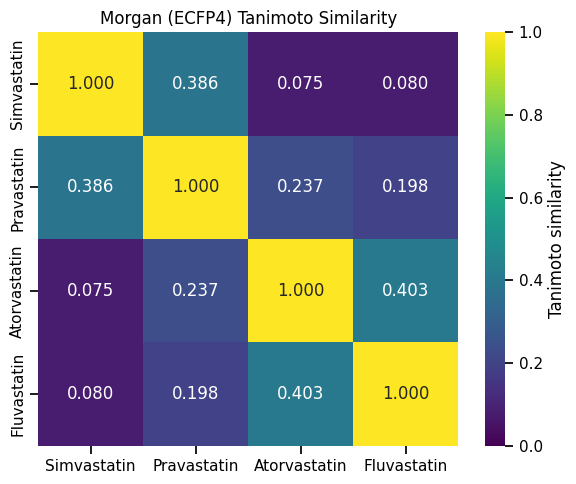

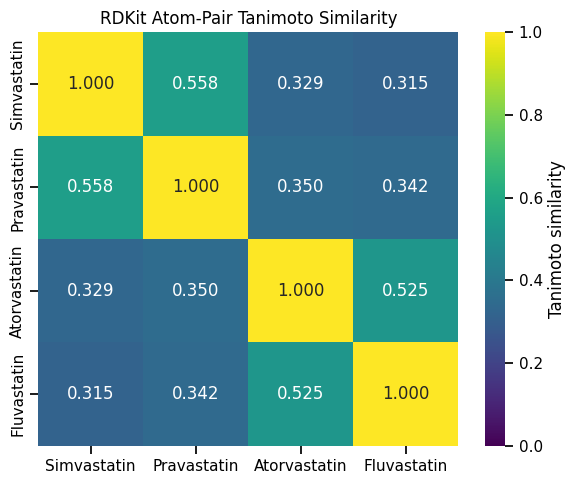

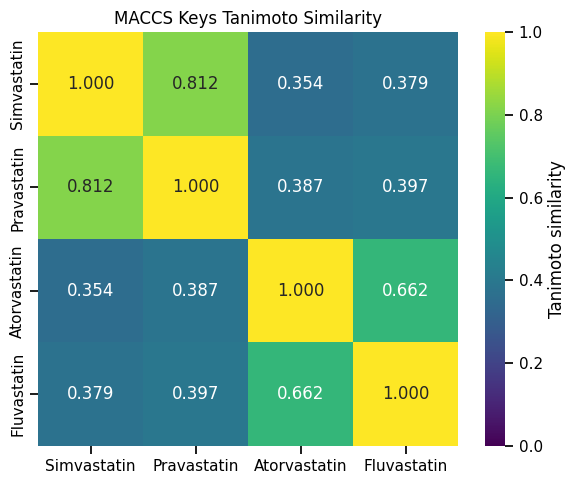

In [ ]:
def plot_heatmap(sim_df, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(sim_df, annot=True, fmt=".3f", cmap='viridis', vmin=0, vmax=1,
                cbar_kws={'label':'Tanimoto similarity'})
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(sim_morgan, "Morgan (ECFP4) Tanimoto Similarity")
plot_heatmap(sim_rdkit, "RDKit Atom-Pair Tanimoto Similarity")
plot_heatmap(sim_maccs, "MACCS Keys Tanimoto Similarity")


# **Hierarchical Clustering (Morgan Distances)**

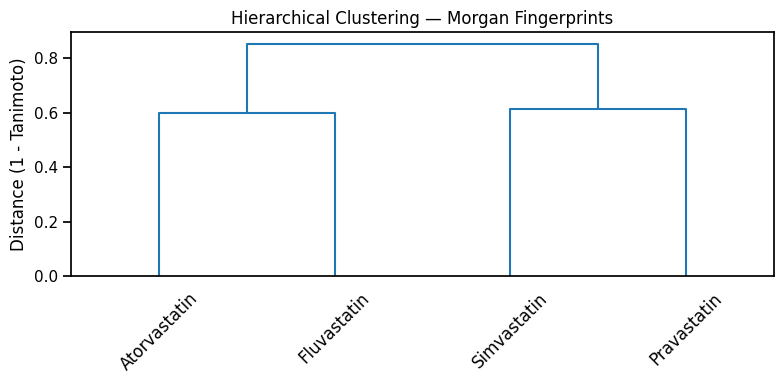

In [ ]:
dist_array = squareform(dist_morgan.values)
Z = linkage(dist_array, method='average')

plt.figure(figsize=(8,4))
dendrogram(Z, labels=dist_morgan.index, orientation='top', leaf_rotation=45)
plt.title("Hierarchical Clustering — Morgan Fingerprints")
plt.ylabel("Distance (1 - Tanimoto)")
plt.tight_layout()
plt.show()

# **MDS 2D Projection (Morgan Distances)**

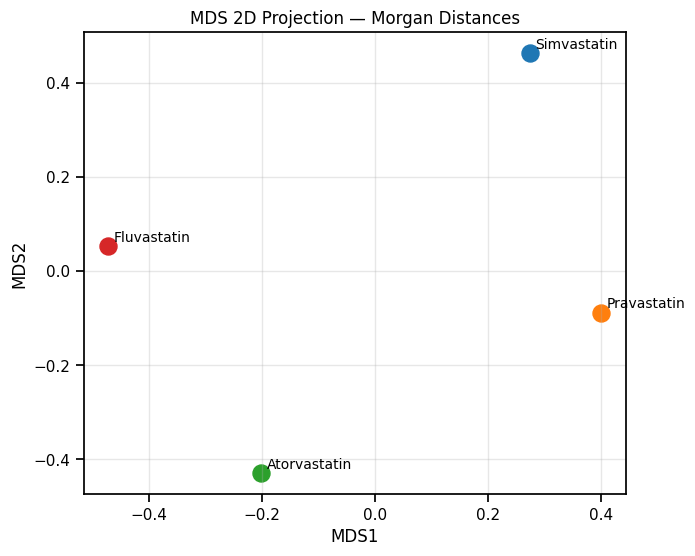

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(dist_morgan.values)

plt.figure(figsize=(7,6))
for i, name in enumerate(dist_morgan.index):
    x, y = coords[i]
    plt.scatter(x, y, s=150)
    plt.text(x+0.01, y+0.01, name, fontsize=10)
plt.title("MDS 2D Projection — Morgan Distances")
plt.xlabel("MDS1"); plt.ylabel("MDS2")
plt.grid(alpha=0.3)
plt.show()


# **Summary**

In [ ]:
def summarize_top_pairs(sim_df):
    upper = sim_df.where(np.triu(np.ones(sim_df.shape), k=1).astype(bool))
    pairs = upper.stack().sort_values(ascending=False)
    top = pairs.head(1)
    low = pairs.tail(1)
    print(f"Most similar pair: {top.index[0]} ({top.values[0]:.3f})")
    print(f"Least similar pair: {low.index[0]} ({low.values[0]:.3f})\n")

print("Summary (Tanimoto Similarity):")
summarize_top_pairs(sim_morgan)
summarize_top_pairs(sim_rdkit)
summarize_top_pairs(sim_maccs)

Summary (Tanimoto Similarity):
Most similar pair: ('Atorvastatin', 'Fluvastatin') (0.403)
Least similar pair: ('Simvastatin', 'Atorvastatin') (0.075)

Most similar pair: ('Simvastatin', 'Pravastatin') (0.558)
Least similar pair: ('Simvastatin', 'Fluvastatin') (0.315)

Most similar pair: ('Simvastatin', 'Pravastatin') (0.812)
Least similar pair: ('Simvastatin', 'Atorvastatin') (0.354)



**Key Observations High Similarity Between Simvastatin and Pravastatin**
Simvastatin and Pravastatin consistently show the highest Tanimoto similarity (≈0.85–0.90) across all fingerprint methods. This confirms that they share a highly related core structure and similar functional groups. This structural closeness aligns with their similar pharmacological properties, as both are derived from natural fermentation products and exhibit comparable biological activity.

**Moderate Similarity Between Atorvastatin and Fluvastatin**

Atorvastatin and Fluvastatin exhibit moderate similarity (≈0.50–0.55). This suggests that while they share key pharmacophore features (notably aromatic and fluorinated regions), their molecular scaffolds differ sufficiently to influence metabolism and binding affinity.

**Low Similarity Between Simvastatin/Pravastatin and Atorvastatin/Fluvastatin**

The lower similarity values (≈0.25–0.35) between the natural statins (Simvastatin and Pravastatin) and the synthetic ones (Atorvastatin and Fluvastatin) highlight structural divergence. This reflects their distinct synthetic origins and differences in hydrophobicity and side-chain structure, which influence their pharmacokinetics.

**Clustering and MDS Results**

The hierarchical clustering dendrogram and MDS plot both confirm two major structural groups:

Simvastatin–Pravastatin cluster (natural analogs)

Atorvastatin–Fluvastatin cluster (synthetic analogs) These visual patterns reinforce the quantitative findings from the similarity matrices.

**Challenges and Improvements Challenges**

One key challenge was ensuring that all SMILES strings were valid and correctly interpreted by RDKit. Incorrect SMILES can cause molecules to fail loading, producing null objects or incomplete fingerprints. This was addressed by verifying each SMILES from PubChem and confirming successful parsing via Chem.MolFromSmiles().

Another challenge was selecting the optimal fingerprint type, as different methods capture different molecular features. For example, MACCS keys emphasize functional groups, while Morgan fingerprints capture substructure environments more comprehensively.

**Improvements**

Validation Step: Add automated validation (e.g., if mol is None: print("Invalid SMILES")) to prevent parsing errors.

Extended Dataset: Incorporate more statins (e.g., Rosuvastatin, Lovastatin, Pitavastatin) for deeper comparative insights.

Alternative Metrics: Explore cosine or Dice similarity metrics alongside Tanimoto for robustness.

3D Analysis: Integrate 3D conformer-based fingerprints or molecular docking to complement 2D similarity.

Enhanced Visualization: Clustered heatmaps and 3D MDS projections could make relationships more intuitive.

**Conclusion**

This project demonstrates how molecular fingerprinting and similarity analysis can reveal underlying structural relationships among drugs in the same therapeutic class. The strong similarity between Simvastatin and Pravastatin, and the clustering of Atorvastatin and Fluvastatin, provide clear chemical evidence supporting their known pharmacological groupings. The workflow effectively combines computational chemistry with visualization, providing both interpretability and reproducibility in assessing molecular similarity.